# 4. Discrimination

In [52]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")
import statsmodels.api as sm
from statsmodels.api import OLS
lc_census_merged14 = pd.read_csv('../data/2014_loan_data/pct_accepted_by_zip3_2014_ALL.csv', dtype={'zip_3':str})
all_loans_2014 = pd.read_csv('../hugo/all_loans_2014', dtype={'ZIP':str}, low_memory = False)
all_loans_2015 = pd.read_csv('../hugo/all_loans_2015', dtype={'ZIP':str}, low_memory = False)
census = pd.read_csv('../data/census_zip3.csv', dtype={'zip_3':str})
loans_bought14 = pd.read_csv('../hugo/loans_bought_2014', dtype={'ZIP':str}, header=1)
loans_bought15 = pd.read_csv('../hugo/loans_bought_2015', dtype={'ZIP':str}, header=1)
loans_bought14.Real_ROI = pd.to_numeric(loans_bought14.Real_ROI, errors='coerce')
loans_bought14.annualized_amnt = pd.to_numeric(loans_bought14.annualized_amnt, errors='coerce')
loans_bought14.amnt = pd.to_numeric(loans_bought14.amnt, errors='coerce')
loans_bought15.Real_ROI = pd.to_numeric(loans_bought15.Real_ROI, errors='coerce')
loans_bought15.annualized_amnt = pd.to_numeric(loans_bought15.annualized_amnt, errors='coerce')
loans_bought15.amnt = pd.to_numeric(loans_bought15.amnt, errors='coerce')
all_loans_2014_merged = all_loans_2014.merge(census, "left", left_on="ZIP", right_on="zip_3")
all_loans_2015_merged = all_loans_2015.merge(census, "left", left_on="ZIP", right_on="zip_3")
loans_bought14_merged = loans_bought14.merge(census, "left", left_on="ZIP", right_on="zip_3")
loans_bought15_merged = loans_bought15.merge(census, "left", left_on="ZIP", right_on="zip_3")
loans_bought15_merged.pct_accepted = pd.to_numeric(loans_bought15_merged.pct_accepted, errors='coerce')

As was estbalished in the introduction, we can define discrimination at either the group level or the individual level. In the context of this project, before even debating which one of these approaches might be more justifiable, it will be important to examine what data we have available to us. Below is a brief summary of what characteristics would be legal or moral grounds for claiming discrimination and what characteristics are available to us through the data.

### What variables are there grounds to use for a discrimination argument?
[Legally protected classes](https://content.next.westlaw.com/Document/Ibb0a38daef0511e28578f7ccc38dcbee/View/FullText.html?contextData=sc.Default&transitionType=Default&firstPage=true&bhcp=1):
* Race
* Color
* Religion or creed
* National origin or ancestry
* Sex
* Age
* Physical or mental disability
* Veteran status
* Genetic information
* Citizenship

Characteristics that are protected by being an Equal Housing Lender (which Lending Club is):
* Race
* Color
* Religion
* National origin
* Sex
* Handicap
* Familial status

Other variables research suggests is correlated to socioeconomic status and other important socio-political outcomes:
* Education
* Unemployment
* Poverty
* Income/wealth

### What characteristics are available to us?

Through LendingClub, these characteristics might be valuable to investigate at the individual-level: 
* Income
* Loan description
* Debt-to-income ratio
* Number of mortgage accounts
* Job description

LendingClub provides the first three digits of each approved applicant's zip code. This allows us to get a sense of the demographics of an individual's area from Census data, which we [re-aggregated at the three-digit zip level](https://github.com/bhavenp/209A-FinalProject/blob/master/anthony/census_data_processing.ipynb) after it was provided to us at the five-digit zip level. Thus, we can examine these Census demographics to get at group-level fairness: 
* Race
* Education
* Family status
* Gender x age
* Unemployment rate
* Workforce
* Household income

<hr>

Moving forward, our potential options for assessing discrimination are as follows:

| Type | Features |
| --- | --- |
| Individual-level fairness | *Income* |
| Group-level fairness | *Race, family status,<br>education, unemployment* |



**comment on why group-level fairness is valid from Cost of Fairness**

Since more information is available at the group-level, we will focus more of our analysis of discrimination on race, family status, education, and unemployment. Specifically, we will examine 
1. whether Lending Club's process of approving loan applicants is correlated to zip code and, in turn, whether it is correlated to these four demographic characteristics of a zip code,
2. whether our lending strategy that hinges around modeling probability of default to maximize return on investment is discriminatory,
3. and whether we can adjust our modeling or investment strategy to reduce the effects of this discrimination while maintaining a high profit.





- hint at terminology and methodologies we will use here; different parity types, LIME, QII, package Lipika found, calibration versus repairing 

## 4.1 Analyzing group-level fairness in the LendingClub process

**explain density plot**

/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


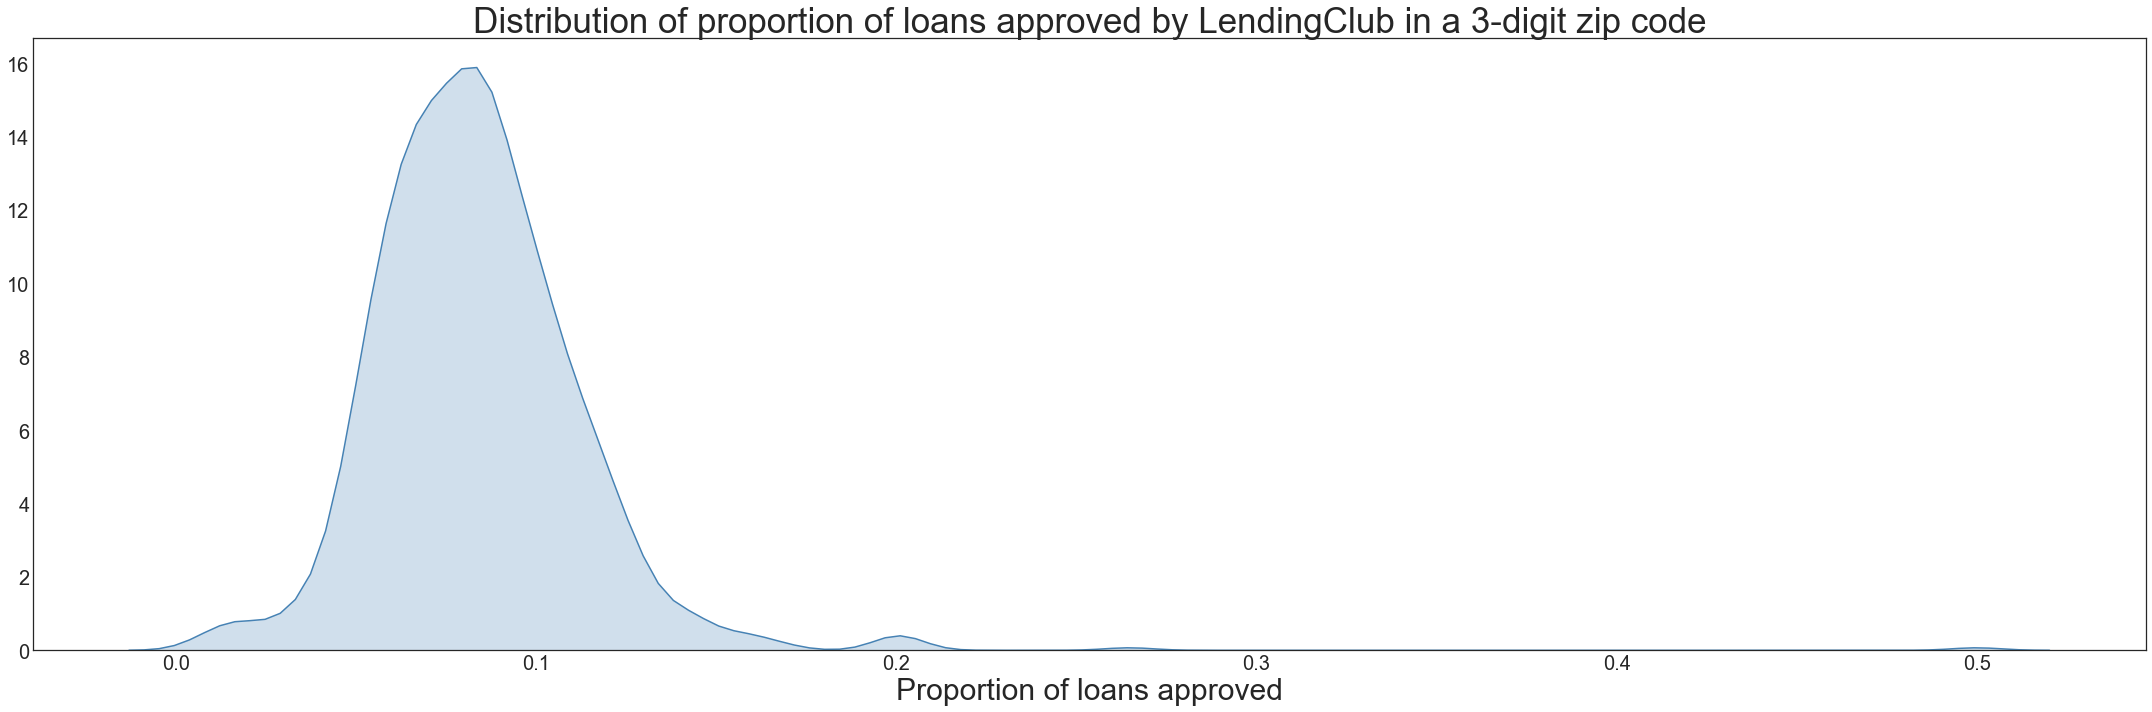

In [38]:
plt.figure(figsize=(30,10))
sns.kdeplot(lc_census_merged14['pct_accepted'].dropna(), shade=True, color='steelblue', legend=False)
plt.xlabel('Proportion of loans approved', fontsize=30)
plt.title('Distribution of proportion of loans approved by LendingClub in a 3-digit zip code', fontsize=35)
plt.tick_params(labelsize=20)
plt.tight_layout()

**explain scatterplots**

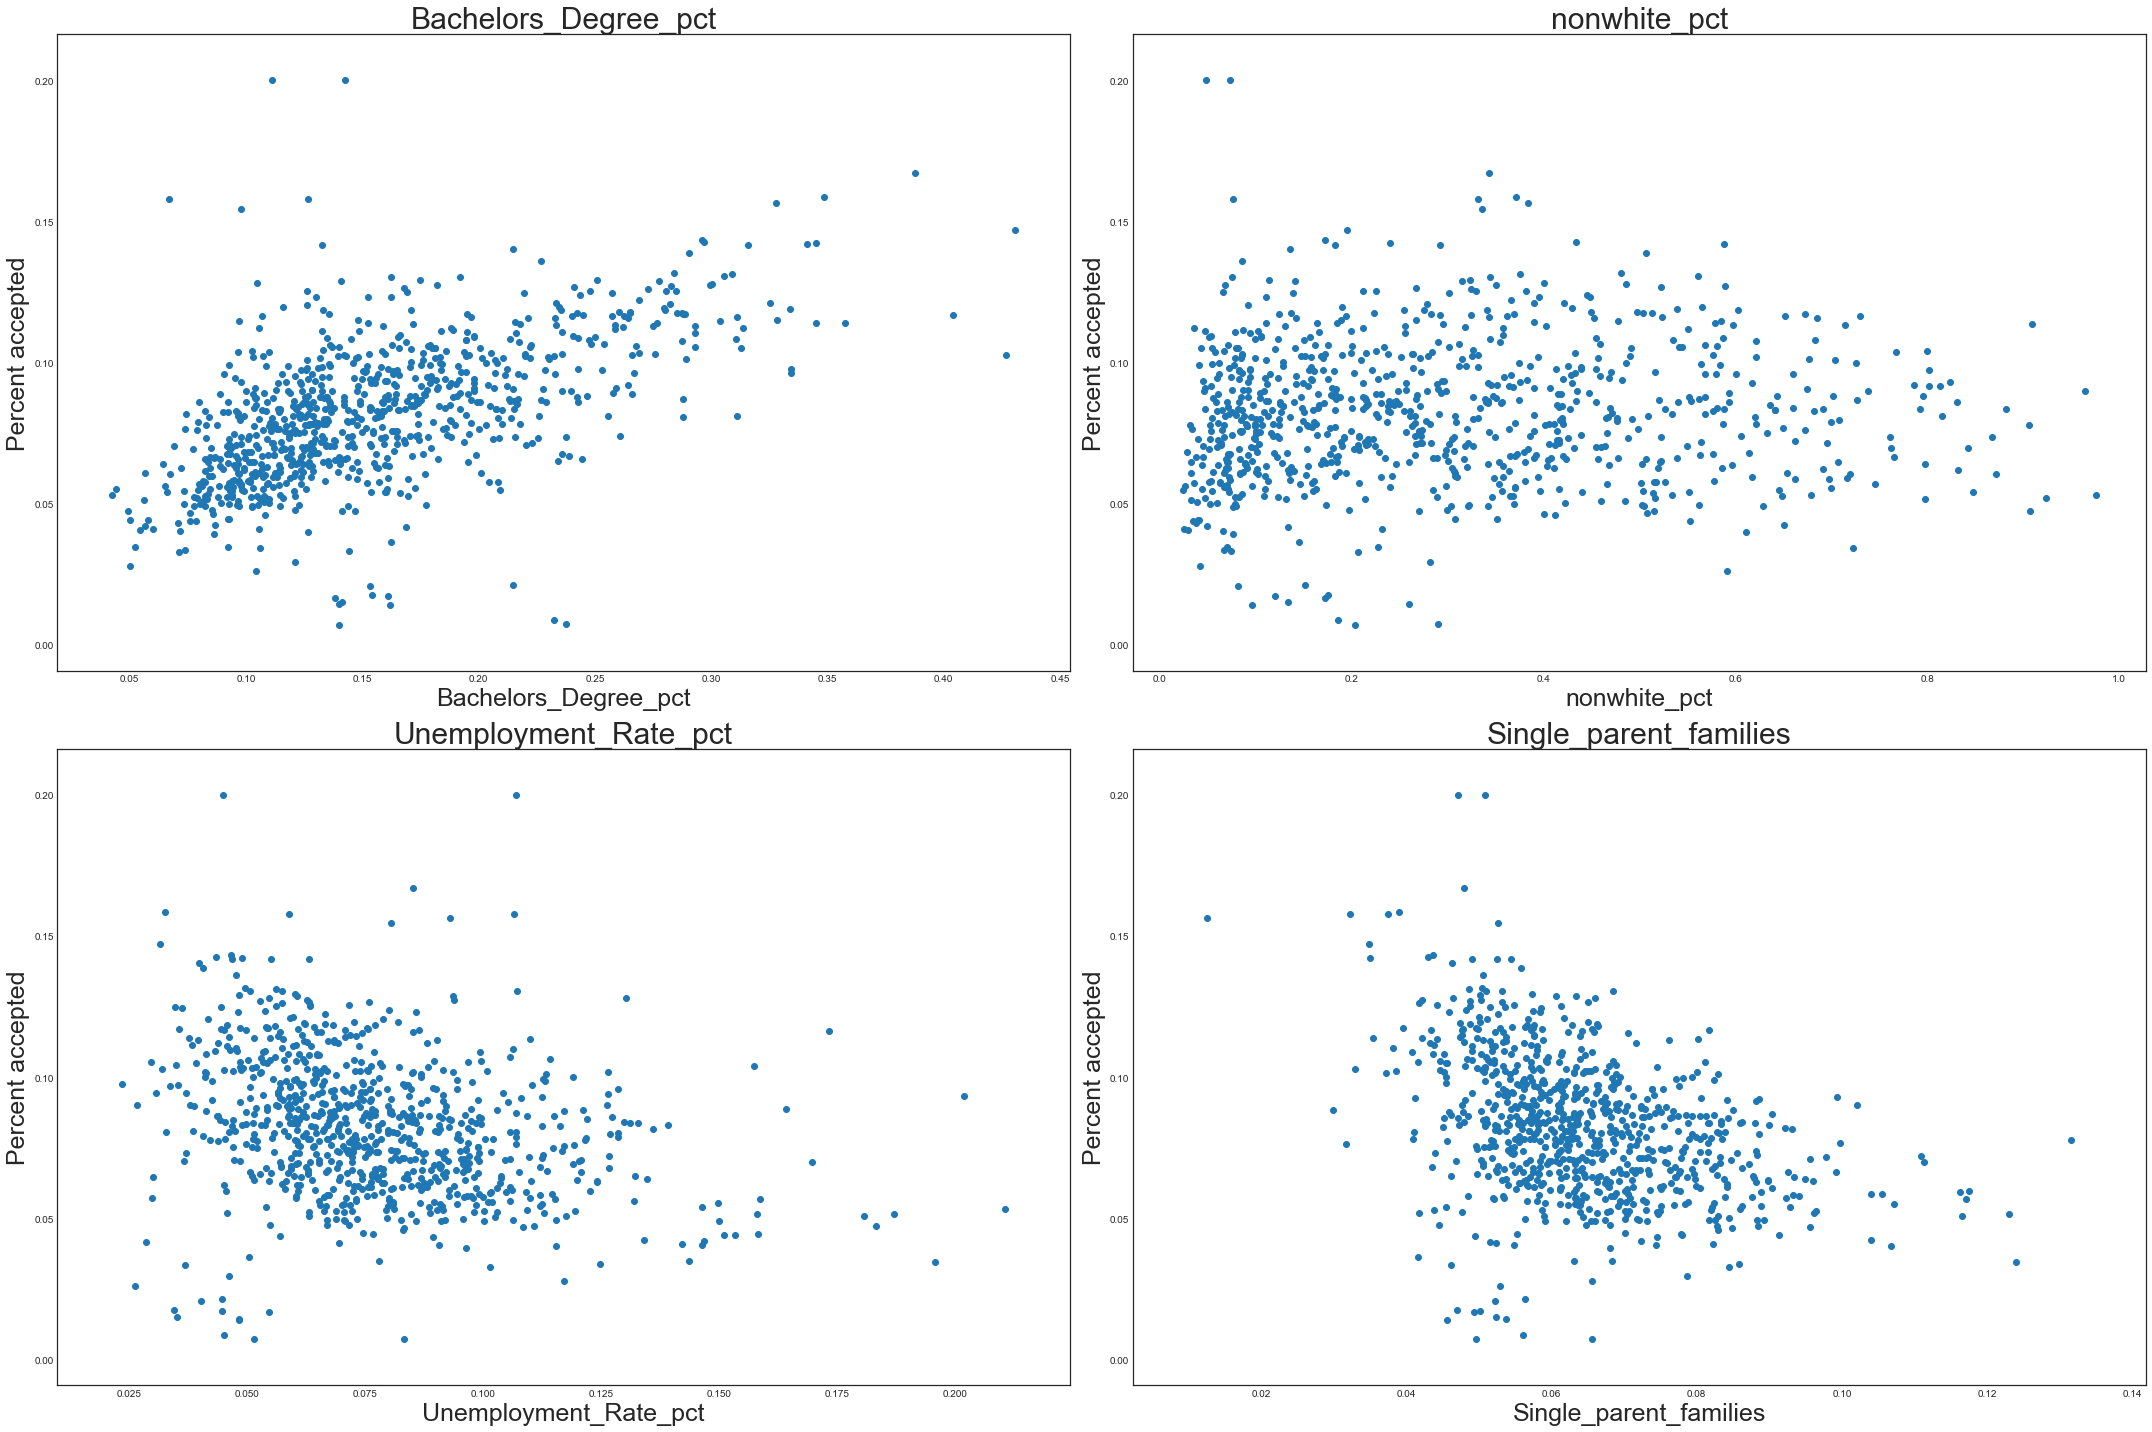

In [32]:
x_cols = ['Bachelors_Degree_pct','nonwhite_pct','Unemployment_Rate_pct', 'Single_parent_families']
fig = plt.figure(figsize=(30,20));
for i, col in enumerate(x_cols):
    ax = plt.subplot(2,2,i+1)
    ax.scatter(lc_census_merged14[col], lc_census_merged14['pct_accepted'])
    ax.set_ylabel('Percent accepted', fontsize=25)
    ax.set_xlabel(col, fontsize=25)
    ax.set_title(col, fontsize=30)
    
plt.tight_layout()

## 4.2 Assessing discrimination in our investment strategy

**explain what coefplots mean**

** mention what model we use - here it is RF**

In [61]:
# function to do coef plot
def coef_plot(reg_obj, title, ax):
    err = reg_obj.params - reg_obj.conf_int()[0]
    coef = pd.DataFrame({'coef': reg_obj.params.values[1:],
                            'err': err.values[1:],
                            'varname': err.index.values[1:]
                           })

    coef.plot(x='varname', y='coef', kind='bar', 
                 ax=ax, color='none', 
                 yerr='err', legend=False)
    ax.set_ylabel(r'$\hat{\beta}$', fontsize=35)
    ax.set_xlabel('')
    ax.scatter(x=pd.np.arange(coef.shape[0]), 
               marker='s', s=120, 
               y=coef['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
    ax.xaxis.set_ticks_position('none')
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.set_title(title, fontsize=40)

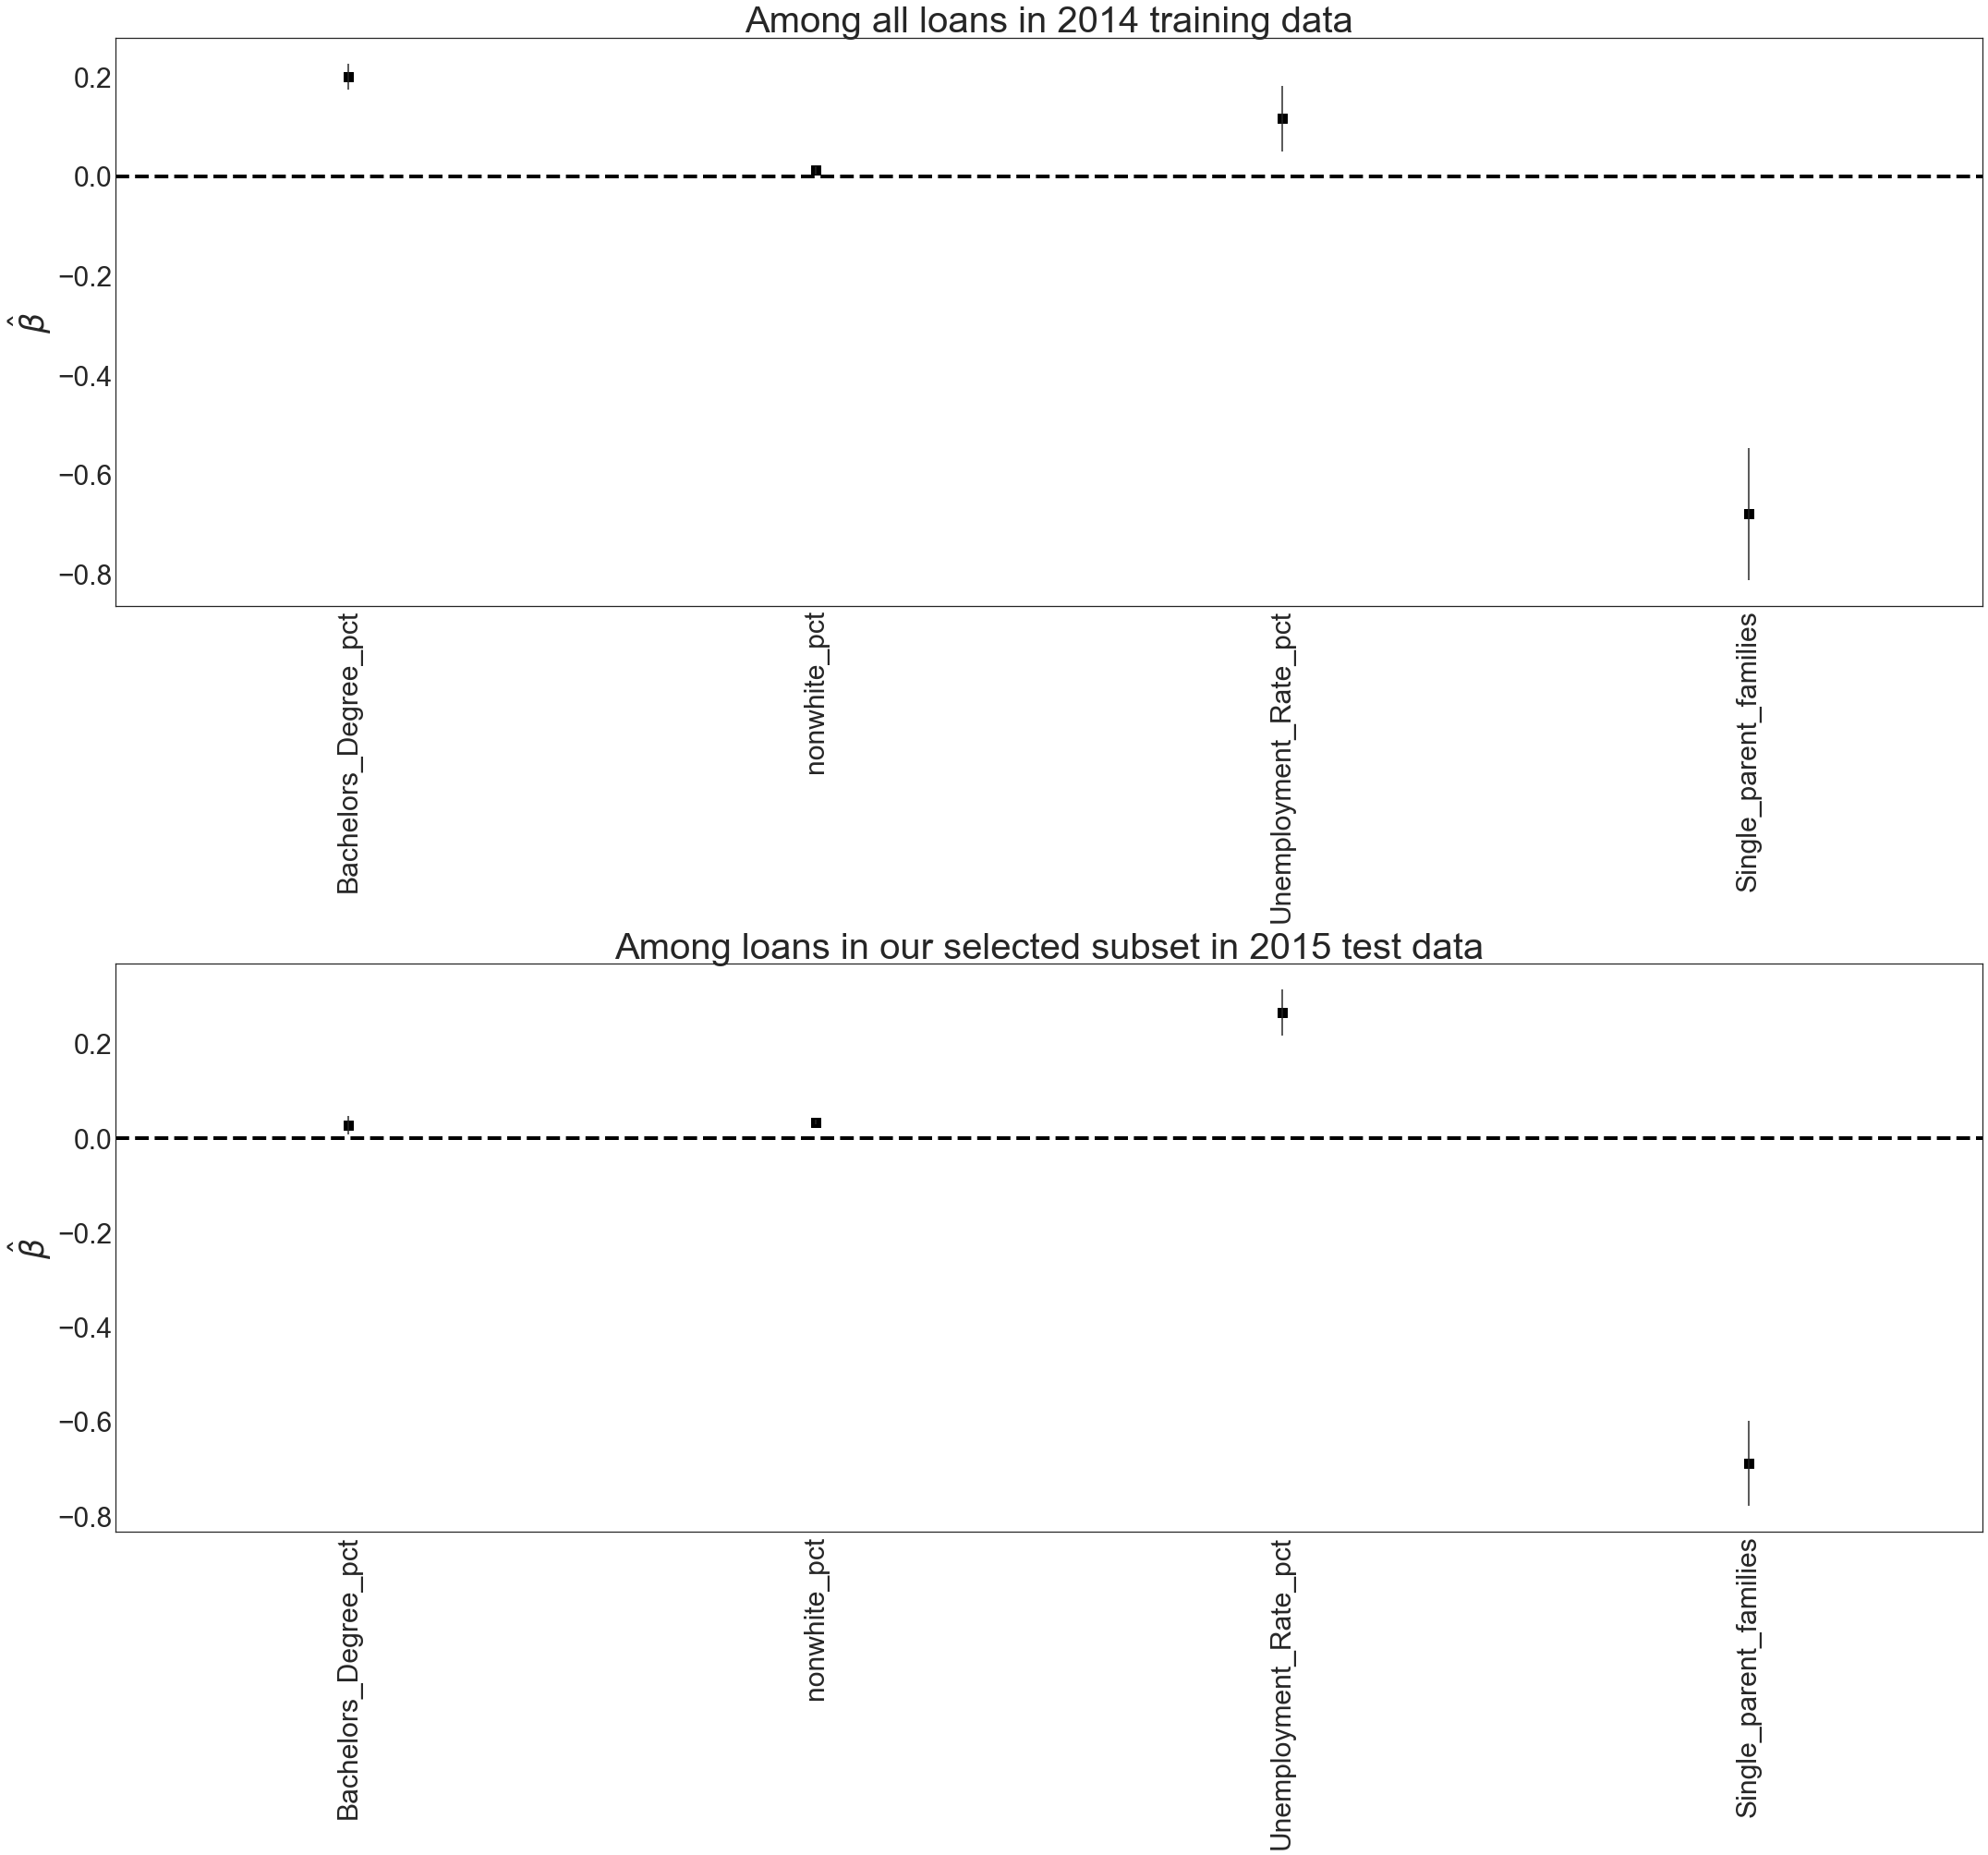

In [63]:
# OLS: pct_accepted ~ demographics for our all loans in training
X = lc_census_merged14[x_cols]
X = sm.add_constant(X)
pct_accepted_census_reg = OLS(lc_census_merged14['pct_accepted'], X, missing='drop').fit()

# OLS: pct_accepted ~ demographics for our selected loans in test
X = loans_bought15_merged[x_cols]
X = sm.add_constant(X)
pct_accepted_census_reg_selected = OLS(loans_bought15_merged['pct_accepted'], X, missing='drop').fit()

fig, ax = plt.subplots(2,1,figsize=(30,28))
coef_plot(pct_accepted_census_reg, 'Among all loans in 2014 training data', ax[0])
coef_plot(pct_accepted_census_reg_selected, 'Among loans in our selected subset in 2015 test data', ax[1])
plt.tight_layout()

In [65]:
def plot_distr_quantiles(feature, score, title, xlabel, ax):
    tiles = np.percentile(feature.dropna(), [0,25,50,75,100])
    _0_25 = feature < tiles[1]
    _25_50 = (feature < tiles[2]) & (feature > tiles[1])
    _50_75 = (feature < tiles[3]) & (feature > tiles[2])
    _75_100 = (feature < tiles[4]) & (feature > tiles[3])

    sns.kdeplot(score[_0_25==True].dropna(), color="green", label="1st quartile", alpha=0.5, ax=ax)
    sns.kdeplot(score[_25_50==True].dropna(), color="purple", label="2nd quartile", alpha=0.5, ax=ax)
    sns.kdeplot(score[_50_75==True].dropna(), color="orange", label="3rd quartile", alpha=0.5, ax=ax)
    sns.kdeplot(score[_75_100==True].dropna(), color="blue", label="4th quartile", alpha=0.5, ax=ax)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_title(title, fontsize=15)
    ax.legend(fontsize=15)

/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


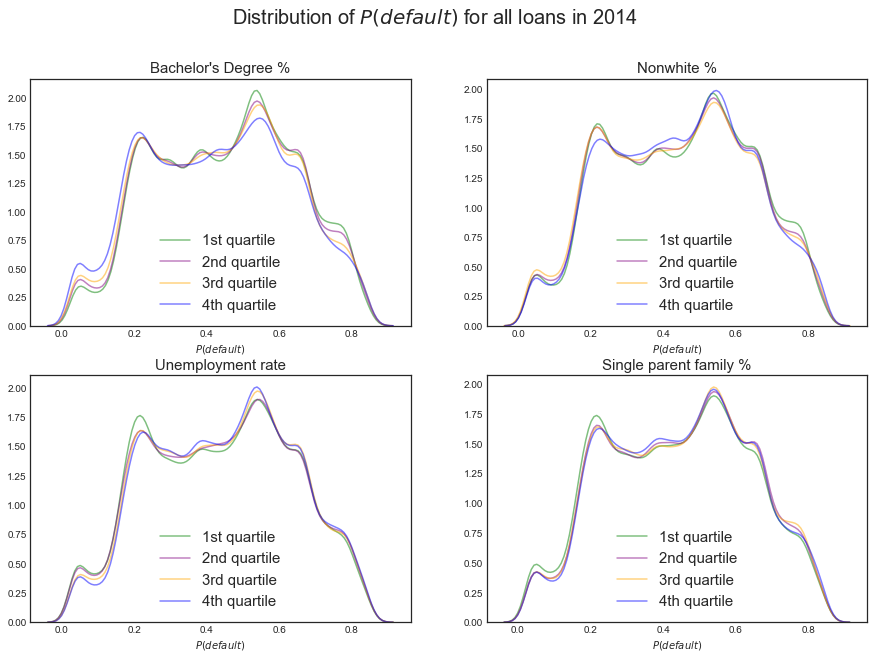

In [66]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
plot_distr_quantiles(all_loans_2014_merged.Bachelors_Degree_pct, all_loans_2014_merged.proba, "Bachelor's Degree %", r"$P(default)$",ax[0,0])
plot_distr_quantiles(all_loans_2014_merged.nonwhite_pct, all_loans_2014_merged.proba, "Nonwhite %", r"$P(default)$",ax[0,1])
plot_distr_quantiles(all_loans_2014_merged.Unemployment_Rate_pct, all_loans_2014_merged.proba, "Unemployment rate", r"$P(default)$", ax[1,0])
plot_distr_quantiles(all_loans_2014_merged.Single_parent_families, all_loans_2014_merged.proba, "Single parent family %", r"$P(default)$", ax[1,1])
plt.suptitle(r"Distribution of $P(default)$ for all loans in training data (2014)", fontsize=20)
plt.show()

/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


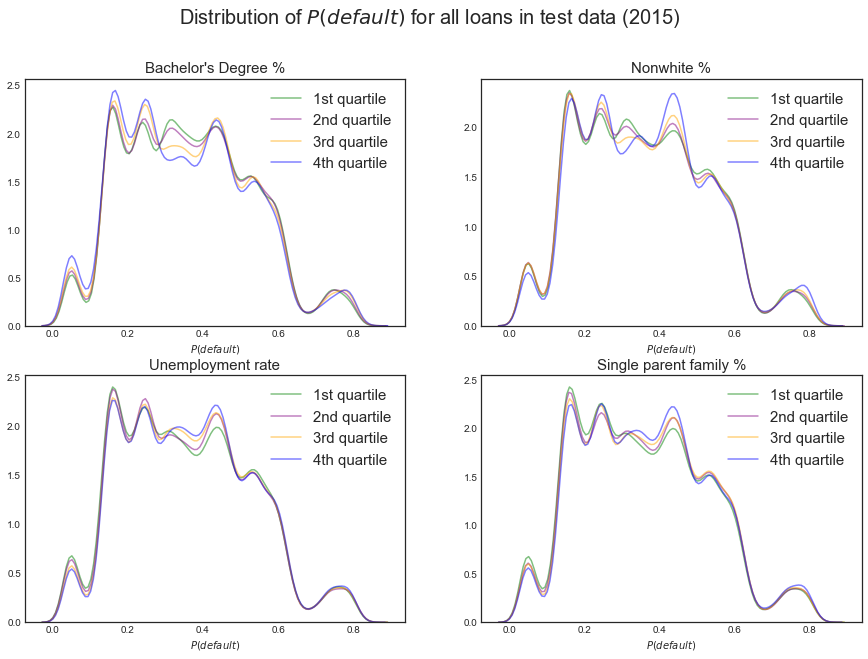

In [67]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
plot_distr_quantiles(all_loans_2015_merged.Bachelors_Degree_pct, all_loans_2015_merged.proba, "Bachelor's Degree %", r"$P(default)$", ax[0,0])
plot_distr_quantiles(all_loans_2015_merged.nonwhite_pct, all_loans_2015_merged.proba, "Nonwhite %", r"$P(default)$", ax[0,1])
plot_distr_quantiles(all_loans_2015_merged.Unemployment_Rate_pct, all_loans_2015_merged.proba, "Unemployment rate", r"$P(default)$", ax[1,0])
plot_distr_quantiles(all_loans_2015_merged.Single_parent_families, all_loans_2015_merged.proba, "Single parent family %", r"$P(default)$", ax[1,1])
plt.suptitle(r"Distribution of $P(default)$ for all loans in test data (2015)", fontsize=20)
plt.show()